# FSL Feat 2

This notebook is a walkthrough of BBX FSL feat2 analysis, including setup, batch submission, and quality checking.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob, os
import subprocess as sp
import pandas as pd
import ipywidgets as widgets

from nilearn import image, plotting
from openpyxl import load_workbook
from shutil import rmtree 

pd.set_option('display.max_rows', 300)
plt.rcParams["figure.figsize"] = (20,15)


In [2]:

from nilearn import plotting

#img='/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-010/ses-1/fsl_feat2/sub-010_ses-1_task-training_19contrasts.gfeat/cope18.feat/stats/zstat1.nii.gz'
#fig = plt.figure(figsize=(12, 6))


#plotting.plot_glass_brain( img, figure=fig, title='Model 2 Example Result | sub-010 cope18: usbtaste+ssbtaste>rinse, zstat file',
 #   black_bg=True, display_mode='lyr', threshold=3, cmap='cool')

#plotting.show()

Setup Variables

In [3]:
study_path="/projects/niblab/experiments/bbx"
sub_ids=[x.split("/")[-1] for x in glob.glob(os.path.join("/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-*"))]
sub_ids.sort()



In [4]:
less_runs=['sub-060', 'sub-002', 'sub-004', 'sub-031', 'sub-042', 'sub-048', 
           'sub-070', 'sub-073', 'sub-076', 'sub-079', 'sub-117', 'sub-128', 
           'sub-133', 'sub-146', 'sub-147', 'sub-148', 'sub-149', 'sub-156']


remove_subs=['sub-029', 'sub-047', 'sub-049', 'sub-069', 'sub-081', 'sub-094', 'sub-101',
             'sub-105', 'sub-106', 'sub-110', 'sub-113', 'sub-122', 'sub-125', 'sub-126', 
             'sub-139', 'sub-155', 'sub-158', 'sub-165']

s2_drop_subjects=["sub-003", 'sub-012','sub-016', 'sub-018',  "sub-020", "sub-024", "sub-025",'sub-026', 'sub-035',
                  "sub-052", 'sub-056', "sub-059", "sub-060", "sub-064","sub-074", "sub-076", "sub-077", 'sub-087',
                  'sub-108', "sub-147", "sub-150", "sub-167"]


## Skipping Registration  

When using the FMRIPREP process we skip registration in FSL feat1 because it was already done in the FMRIPREP process. Before running feat2, *we have to modify the feat1 folders slighty to adjust for this registration difference.*

Full run down video: [skipping registration](https://www.youtube.com/watch?v=U3tG7JMEf7M)  
  
* Check for `reg_standard/` folder, delete if it exists.  
Note, this is only created if a feat2 process has been run, should not exist otherwise.  
  
  
* Delete all `.mat` files in the `reg/` folder, replace with identity matrix.  
`cp $FSLDIR/etc/flirtsch/ident.mat reg/ example_func2standard.mat`  
This ensures the data won't be moved at all.    
  

* Make sure the data isn't interpolated again.  
Essentially means, after the movement the voxels still align exactly.  
`cp mean_func.nii.gz reg/standard.nii.gz`  


In [13]:
class BBXFeat1Modeling:
    
    
    def __init__(self):
        self.data_path='/projects/niblab/experiments/bbx/data'
    
    def skipping_registration(self, sub_data_path,folder_tag, verbose=False):
        
        if verbose==True: print('[INFO] running skipping reg process for %s'%sub_data_path.split("/")[-2])
        feat_folders=glob.glob(os.path.join(
                sub_data_path, "fsl_feat1/*%s.feat"%folder_tag))

        feat_folders.sort()

        # loop through subject feat1 folders
        for feat_folder in feat_folders:

            # get .mat files for subject
            mat_files = glob.glob(os.path.join(feat_folder, "reg/*.mat"))

            # loop through .mat files found 
            for mat_file in mat_files:        

                if verbose==True: print("\n[INFO] removing .mat files \n%s"%mat_file)

                try:
                    os.remove(mat_file)
                except Exception as e:
                    print(e)

            # Remove reg_standard directories

            reg_std_folder = os.path.join(feat_folder, "reg_standard")# reg_standard/ directories 

            if os.path.exists(reg_std_folder):
                if verbose==True: print("\n[INFO] removing reg_standard/ directory \n%s"%reg_std_folder)

                # remove folder
                try:
                    rmtree(reg_std_folder)

                except Exception as e:
                    print(e)        

            # Copy identity matrix
            reg_folders = glob.glob(os.path.join(sub_data_path, "fsl_feat1/*run*%s.feat/reg"%folder_tag))
            
            for reg in reg_folders:
                path="%s/example_func2standard.mat"%reg
                copy_mat_cmd='cp $FSLDIR/etc/flirtsch/ident.mat %s'%path

                if verbose==True: print("\n[INFO] copying identity matrix \n%s"%copy_mat_cmd)

                try:
                    sp.run(copy_mat_cmd, shell=True)
                except Exception as e:
                    print(e)

            # copy mean files           
            MEAN_PATH = os.path.join(feat_folder, "mean_func.nii.gz")
            REG_DIR = os.path.join(feat_folder, "reg", "standard.nii.gz")

            copy_mean_cmd = 'cp %s %s'%(MEAN_PATH, REG_DIR)
            if verbose==True: print("\n[INFO] copying mean file \n%s"%copy_mean_cmd)
            sp.run(copy_mean_cmd, shell=True)





In [31]:

obj=BBXFeat1Modeling()
base_path='/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed' 
task="task-training"
session='ses-2'
for sub in ['sub-025']: #sub_ids:
    subject=sub
    subject_path=os.path.join(base_path,subject, session)

    # call the skipping_registration() method
    # subject_path = the preprocessed folder, where feat1 folder is held
    # verbose = True, verbose=False by default
    obj.skipping_registration(subject_path, '19contrasts',False)
    
print('[INFO] process complete.')


[INFO] process complete.


---

## Make Files -

In [32]:
def setup_feat2(sub_folder, folder_tag, verbose=True, make_dir=True):
        # set variables
        subject = sub_folder.split("/")[-2]
        session = sub_folder.split("/")[-1]
        filename="%s_%s_task-training_%s"%(subject, session, folder_tag)
        
        #check for existence of feat2 directory
        feat2_path = os.path.join(sub_folder, "fsl_feat2")

        if make_dir==True:
            if os.path.exists(feat2_path):
                #if verbose==True: print('[INFO] path %s already exists'%feat2_path)
                pass
            else:
                os.makedirs(feat2_path)


        # setup variables to fill fsf file

        # get feat1 paths
        feat1_path = os.path.join(sub_folder, "fsl_feat1/*%s.feat"%folder_tag)
        feat1_folders = sorted(glob.glob(feat1_path)) 
        feat1_ct=len(feat1_folders)
        #if verbose==True: print("[INFO] %s feat1 folders found"%feat1_ct)

        if feat1_ct == 4:

            design_file="/projects/niblab/experiments/bbx/data/feat_design_files/model2.fsf"


            # open fsf template file
            with open(os.path.join(design_file), 'r') as infile:
                tempfsf=infile.read()
                # set outpath for fsf OUTPATH variable, by run
                sub_id =  sub_folder.split("/")[-2]
                outpath = os.path.join(feat2_path, 
                       '%s'%(filename))
                print('[INFO] outpath: ', outpath)
                tempfsf = tempfsf.replace("OUTPUT", outpath)

                # fill in feat1 folder paths
                for index,feat_path in enumerate(feat1_folders):
                    feat_id = "run%s"%(index+1)
                    tempfsf = tempfsf.replace(feat_id, feat_path)

                # view fsf file 
                #print("\n\n", tempfsf)

                # setup outfile path for fsf file
                OUTFILE_PATH = os.path.join(feat2_path, "%s.fsf"%(filename))
                #if verbose ==True: print("[INFO] writing to file: ", OUTFILE_PATH)
                # write the new fsf to the fsf file path
                with open(OUTFILE_PATH, "w") as outfile:
                    outfile.write(tempfsf)
                outfile.close()
            infile.close()

        elif feat1_ct==3:
            design_file="/projects/niblab/experiments/bbx/data/feat_design_files/model2.3.fsf"


            # open fsf template file
            with open(os.path.join(design_file), 'r') as infile:
                tempfsf=infile.read()
                # set outpath for fsf OUTPATH variable, by run
                sub_id =  sub_folder.split("/")[-2]
                outpath = os.path.join(feat2_path, 
                       '%s'%(filename))
                #print('[INFO] outpath: ', outpath)
                tempfsf = tempfsf.replace("OUTPUT", outpath)

                # fill in feat1 folder paths
                for index,feat_path in enumerate(feat1_folders):
                    feat_id = "run%s"%(index+1)
                    tempfsf = tempfsf.replace(feat_id, feat_path)

                # view fsf file 
                #print("\n\n", tempfsf)

                # setup outfile path for fsf file
                OUTFILE_PATH = os.path.join(feat2_path, "%s.fsf"%(filename))
                if verbose ==True: print("[INFO] writing to file: ", OUTFILE_PATH)
                # write the new fsf to the fsf file path
                with open(OUTFILE_PATH, "w") as outfile:
                    outfile.write(tempfsf)
                outfile.close()
            infile.close()

        elif feat1_ct==2:
            design_file="/projects/niblab/experiments/bbx/data/feat_design_files/model2.2.fsf"


            # open fsf template file
            with open(os.path.join(design_file), 'r') as infile:
                tempfsf=infile.read()
                
                # set outpath for fsf OUTPATH variable, by run
                sub_id =  sub_folder.split("/")[-2]
                outpath = os.path.join(feat2_path, '%s'%(filename))
                
                #print('[INFO] outpath: ', outpath)
                tempfsf = tempfsf.replace("OUTPUT", outpath)

                # fill in feat1 folder paths
                for index,feat_path in enumerate(feat1_folders):
                    feat_id = "run%s"%(index+1)
                    tempfsf = tempfsf.replace(feat_id, feat_path)

                # setup outfile path for fsf file
                OUTFILE_PATH = os.path.join(feat2_path, "%s.fsf"%(filename))
                if verbose ==True: print("[INFO] writing to file: ", OUTFILE_PATH)
                    
                # write the new fsf to the fsf file path
                with open(OUTFILE_PATH, "w") as outfile:
                    outfile.write(tempfsf)
                outfile.close()
            infile.close()
        else:

            pass

        #if verbose==True: print('[INFO] process complete')


In [33]:
 sub_ids[:4]

['sub-001', 'sub-002', 'sub-003', 'sub-004']

In [34]:
# variables
base_path='/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed' 
task="task-training"
session='ses-2'

for sub in sub_ids:

    subject=sub
    subject_path=os.path.join(base_path,subject, session)
    setup_feat2(subject_path, '19contrasts', verbose=True)



[INFO] outpath:  /projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-001/ses-2/fsl_feat2/sub-001_ses-2_task-training_19contrasts
[INFO] outpath:  /projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-002/ses-2/fsl_feat2/sub-002_ses-2_task-training_19contrasts
[INFO] outpath:  /projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-004/ses-2/fsl_feat2/sub-004_ses-2_task-training_19contrasts
[INFO] writing to file:  /projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-005/ses-2/fsl_feat2/sub-005_ses-2_task-training_19contrasts.fsf
[INFO] outpath:  /projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-006/ses-2/fsl_feat2/sub-006_ses-2_task-training_19contrasts
[INFO] outpath:  /projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-007/ses-2/fsl_feat2/sub-007_ses-2_task-training_19contrasts
[INFO] outpath:  /projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-008/ses-2/fsl_feat2/sub-008_ses-2

## Batch jobs submission

In [15]:

def run_slurm(start, finish, batch_size, session, file_ext):
    if run_bash == True:
        bash_file = os.path.join('/projects/niblab/experiments/bbx/code/preprocessing/fsl_feat2'
                                 , 'feat2.job')



        #for session in ['ses-1', 'ses-2']:
        shell_cmd = "sbatch --array={}-{}%{} {} {} {}".format(start, finish, 
                                                   batch_size, bash_file, file_ext, session)
        sp.run(shell_cmd, shell=True)
        print('[INFO] submitted: ', shell_cmd)


        #for sub_num in subject_set:
            #shell_cmd = "sbatch --array={}%1 {}".format(sub_num, bash_file)
            #os.system(shell_cmd)
            #print(shell_cmd)




In [37]:
run_bash=True
start=25
finish=25
batch_size=1
file_ext="ses-2_task-training_19contrasts.fsf"
session="ses-2"
run_slurm(start, finish, batch_size, session, file_ext)

[INFO] submitted:  sbatch --array=25-25%1 /projects/niblab/experiments/bbx/code/preprocessing/fsl_feat2/feat2.job ses-2_task-training_19contrasts.fsf ses-2


In [ ]:
# run individual batch jobs
submission_list=sub_ids
for x in submission_list[1:]:
    x=x.split("-")[1].lstrip('0')
    start=x
    finish=x
    batch_size=1
    session="ses-1"

    run_slurm(start, finish, batch_size, session, file_ext)

---
---
---

---  
## Quality Check

In [5]:
#get good files ct
s1_subjects_good=[x.split('/')[-4].split("_")[0] for x in glob.glob('/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-*/ses-1/fsl_feat2/*19contrasts.gfeat/cope1.feat/stats/cope1.nii.gz')]
session1_feat2=glob.glob('/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-*/ses-1/fsl_feat2/*19contrasts.gfeat')
s1_subjects_good.sort()                


# get feats
#session1_feat2=glob.glob(
 #   '/projects/niblab/experiments/bbx/data/preprocessed/sub-*/ses-1/fsl_feat2/sub-*.gfeat')

#get good files ct
#s2_subjects_good=[x.split('/')[-4].split("_")[0] for x in glob.glob('/projects/niblab/experiments/bbx/data/preprocessed/sub-*/ses-2/fsl_feat2/*.gfeat/cope1.feat/stats/cope1.nii.gz')]
#session2_feat2=glob.glob('/projects/niblab/experiments/bbx/data/preprocessed/sub-*/ses-2/fsl_feat2/*.gfeat/cope1.feat/stats/cope1.nii.gz')
#s2_subjects_good.sort()                



# get feats
#session2_feat2=glob.glob(
 #   '/projects/niblab/experiments/bbx/data/preprocessed/sub-*/ses-2/fsl_feat2/sub-*.gfeat')




print('\n[SESSION1] %s feat2 folders found'%len(session1_feat2))                     
print('[SESSION1] %s subjects found for feat3'%len(s1_subjects_good))
#print('\n[SESSION2] %s feat2 folders found'%len(session2_feat2))                     
#print('[SESSION2] %s subjects found for feat3'%len(s2_subjects_good))


[SESSION1] 149 feat2 folders found
[SESSION1] 148 subjects found for feat3


In [6]:
class BBXFeat2Reports:
    
    def __init__(self):
        self.data_path='/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed'
        
    def feat2_qc(self, tag, sess):
        feat2_dict={}
        feat2=glob.glob(os.path.join(self.data_path,'sub-*/%s/fsl_feat2/*%s.gfeat'%(sess,tag)))
        feat2.sort()

        for feat2_folder in feat2:

            subject=feat2_folder.split("/")[-4].split("_")[0]

            if subject not in feat2_dict:
                feat2_dict[subject]={}

            # collect data files count
            copes=glob.glob(os.path.join(feat2_folder,"cope*/stats/cope1.nii.gz"))
            zstats=glob.glob(os.path.join(feat2_folder, 'cope*/stats/zstat1.nii.gz'))

            copes.sort()
            zstats.sort()

            feat2_dict[subject]['cope_ct']=len(copes)
            feat2_dict[subject]['zstat_ct']=len(zstats)


            """for cope in copes:
                cope_id=cope.split("/")[-1].split(".")[0]

                cope_file=os.path.join(cope, 'stats/cope1.nii.gz')
                #zstats=glob.glob(os.path.join(cope, "stats/zstat1.nii.gz"))
                cp_ct+=1
                # get activation
                cmd_out= sp.check_output(["fslstats", cope_file, '-M'])
                cmd_out=cmd_out.decode("utf-8")

                feat2_dict[subject]["%s_file_mean"%(cope_id)]=cmd_out.strip('\n')
                #feat2_dict[subject]['%s_ct'%cope_id]=len(zstats)"""




        #print(feat2_dict)        
        feat2_df=pd.DataFrame(feat2_dict).T

        return feat2_df;


In [7]:
obj=BBXFeat2Reports()

In [8]:
s1_f2=obj.feat2_qc('19contrasts', 'ses-1' )
s1_f2.sort_index(inplace=True)

s1_f2[s1_f2.notnull().all(axis=1)]


,cope_ct,zstat_ct
sub-001,19,19
sub-002,19,19
sub-003,19,19
sub-004,19,19
sub-005,19,19
sub-006,19,19
sub-007,19,19
sub-008,19,19
sub-009,19,19
sub-010,19,19


In [9]:
s1_f2[s1_f2['cope_ct']==19].index.values

array(['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006',
       'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-012',
       'sub-013', 'sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-018',
       'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024',
       'sub-025', 'sub-026', 'sub-027', 'sub-028', 'sub-030', 'sub-031',
       'sub-032', 'sub-033', 'sub-034', 'sub-035', 'sub-036', 'sub-037',
       'sub-038', 'sub-039', 'sub-040', 'sub-041', 'sub-042', 'sub-043',
       'sub-044', 'sub-045', 'sub-046', 'sub-048', 'sub-050', 'sub-051',
       'sub-052', 'sub-053', 'sub-054', 'sub-055', 'sub-056', 'sub-057',
       'sub-058', 'sub-059', 'sub-060', 'sub-061', 'sub-062', 'sub-063',
       'sub-064', 'sub-065', 'sub-066', 'sub-067', 'sub-068', 'sub-070',
       'sub-071', 'sub-072', 'sub-073', 'sub-075', 'sub-076', 'sub-077',
       'sub-078', 'sub-079', 'sub-080', 'sub-082', 'sub-083', 'sub-084',
       'sub-085', 'sub-086', 'sub-087', 'sub-088', 

**Session-2**

In [10]:
s2_f2=obj.feat2_qc('19contrasts', 'ses-2' )
s2_f2.sort_index(inplace=True)

s2_f2[s2_f2.notnull().all(axis=1)]



,cope_ct,zstat_ct
sub-001,19,19
sub-002,19,19
sub-004,19,19
sub-005,19,19
sub-006,19,19
sub-007,19,19
sub-008,19,19
sub-009,19,19
sub-010,19,19
sub-011,19,19


**What subjects are missing cope folders?**

In [11]:
s2_f2[s2_f2['cope_ct']<19]

,cope_ct,zstat_ct


**What subjects have all copes?**

In [12]:
s2_f2[s2_f2['cope_ct']==19]

,cope_ct,zstat_ct
sub-001,19,19
sub-002,19,19
sub-004,19,19
sub-005,19,19
sub-006,19,19
sub-007,19,19
sub-008,19,19
sub-009,19,19
sub-010,19,19
sub-011,19,19


In [13]:
s2_f2[s2_f2['cope_ct']==19].index.values

array(['sub-001', 'sub-002', 'sub-004', 'sub-005', 'sub-006', 'sub-007',
       'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-013', 'sub-014',
       'sub-015', 'sub-017', 'sub-019', 'sub-020', 'sub-021', 'sub-022',
       'sub-023', 'sub-024', 'sub-025', 'sub-028', 'sub-030', 'sub-031',
       'sub-032', 'sub-033', 'sub-034', 'sub-035', 'sub-036', 'sub-037',
       'sub-038', 'sub-039', 'sub-040', 'sub-041', 'sub-042', 'sub-043',
       'sub-044', 'sub-045', 'sub-046', 'sub-048', 'sub-050', 'sub-051',
       'sub-052', 'sub-053', 'sub-054', 'sub-055', 'sub-057', 'sub-058',
       'sub-061', 'sub-062', 'sub-063', 'sub-065', 'sub-066', 'sub-067',
       'sub-068', 'sub-070', 'sub-071', 'sub-072', 'sub-073', 'sub-074',
       'sub-075', 'sub-077', 'sub-078', 'sub-079', 'sub-080', 'sub-082',
       'sub-083', 'sub-084', 'sub-085', 'sub-086', 'sub-087', 'sub-088',
       'sub-089', 'sub-090', 'sub-092', 'sub-093', 'sub-095', 'sub-096',
       'sub-097', 'sub-098', 'sub-099', 'sub-100', 

In [14]:
len(s2_f2[s2_f2['cope_ct']==19].index.values)

130

---

In [15]:
study_path

'/projects/niblab/experiments/bbx'

In [16]:
datapath='/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed'

### Plot model brains

In [17]:
def plot_feat2( cope,sess,ext):
    
    filepath=os.path.join(study_path, 'data/preprocessed', 
                        'subs_trimmed/sub-*/%s/fsl_feat2/*%s.gfeat/%s.feat/stats/tstat1.nii.gz'%(sess, ext, cope))
    
    
    nrows=10
    ncols=5
    
    tmaps=glob.glob(filepath)
    tmaps.sort()
    
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,15))
                    
    for midx, tmap in enumerate(tmaps[:50]):

        settings=axes[int(midx / ncols), int(midx % ncols)]

        #print(int(midx / nrows) ,int(midx % nrows))
        
        sub=tmap.split("/")[-7]

        title_str="%s %s"%(sub, cope)

        plotting.plot_glass_brain(tmap, colorbar=False, threshold=2.0, cmap='spring',
                          axes=settings,
                          plot_abs=False, display_mode='z', title=title_str) 

    fig.suptitle('subjects tmap taste network')
    plotting.show()

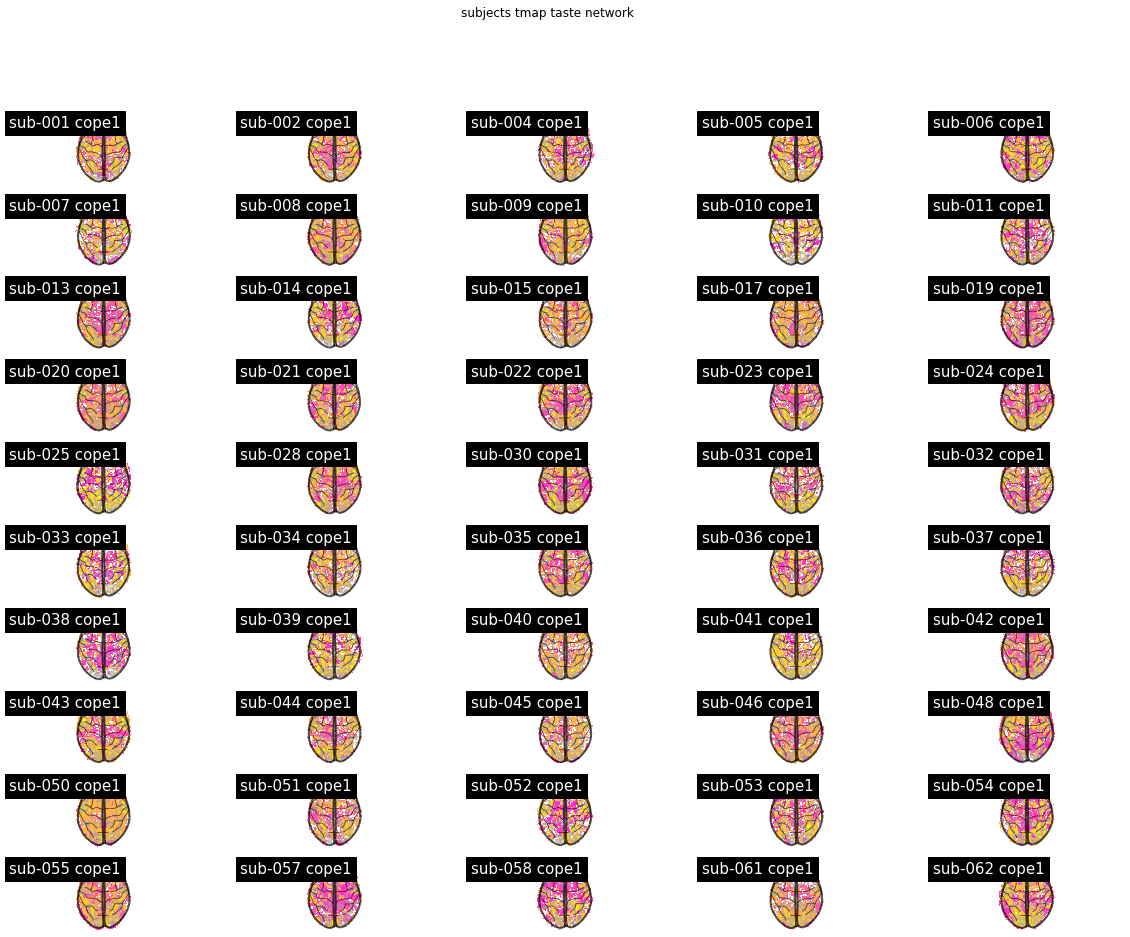

In [18]:
from nilearn import plotting
from scipy.stats import norm
plot_feat2( 'cope1', 'ses-2','19contrasts')



In [19]:
def plot_feat2( sub,sess,ext):
    
    filepath=os.path.join(study_path, 'data/preprocessed', 
                        'subs_trimmed/%s/%s/fsl_feat2/*%s.gfeat/cope*.feat/stats/tstat1.nii.gz'%(sub, sess, ext))
    
    
    nrows=4
    ncols=5
    
    tmaps=glob.glob(filepath)
    #tmaps=sorted(tmaps, key=lambda x: int(x.replace('/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/%s/%s/fsl_feat2/*%s_%s_task-training_19contrasts.gfeat/cope'%(sub, sess, sub, sess), '').replace('.feat/stats/tstat1.nii.gz', '')))

    tmaps.sort()
    
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,15))
                    
    for midx, tmap in enumerate(tmaps):

        settings=axes[int(midx / ncols), int(midx % ncols)]

        #print(int(midx / nrows) ,int(midx % nrows))
        
        sub=tmap.split("/")[-7]
        cope=tmap.split("/")[-3].split('.')[0]
        
        title_str="%s %s"%(sub, cope)

        plotting.plot_glass_brain(tmap, colorbar=False, threshold=2.0, cmap='spring',
                          axes=settings,
                          plot_abs=False, display_mode='z', title=title_str) 

    fig.suptitle('subject 1 copes', fontsize=30)
    fig.delaxes(axes[3][4])
    plotting.show()

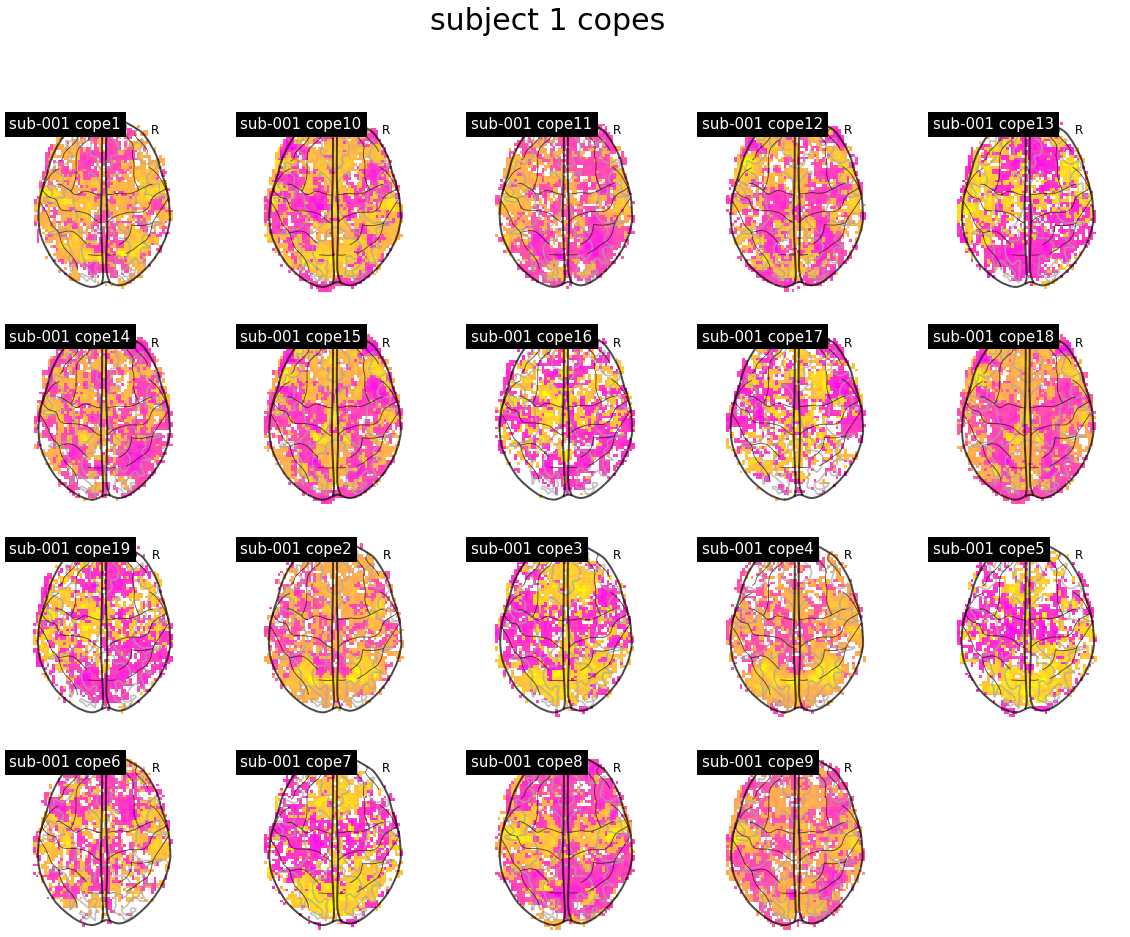

In [20]:
from nilearn import plotting
from scipy.stats import norm
plot_feat2( 'sub-001', 'ses-2','19contrasts')



### Interactive View

In [113]:

def interactive_zstat(sub_id='sub-001', sess="ses-1", cope='cope1'):
    
    print("[INFO] viewing report for %s"%sub_id)
    try:
        stat_img='/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/%s/%s/fsl_feat2/%s_%s_task-training_19contrasts.gfeat/%s.feat/stats/zstat1.nii.gz'%(sub_id, sess, sub_id, sess, cope)

        #print(stat_img)

        view = plotting.view_img(stat_img, threshold=3)
        # In a Jupyter notebook, if ``view`` is the output of a cell, it will
        # be displayed below the cell
        display(view)
    except: print('[INFO] ERROR NO DATA FOUND')



In [114]:
cope_ids=['cope1', 'cope2', 'cope3', 'cope4', 'cope5', 'cope6', 'cope7',
          'cope8', 'cope9', 'cope10', 'cope11', 'cope12', 'cope13', 'cope14',
          'cope15', 'cope16', 'cope17', 'cope18', 'cope19']

sessions=['ses-1', 'ses-2']

In [115]:
sub_ids.sort()
w= widgets.Select(options=sub_ids)
widgets.interactive(interactive_zstat, sub_id=sub_ids, sess=sessions, cope=cope_ids)

interactive(children=(Dropdown(description='sub_id', options=('sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub…

---

## Write Files

In [20]:
path='/projects/niblab/experiments/bbx/data/quality_analysis/bbx-trimmed_report.xlsx'


In [21]:
writer = pd.ExcelWriter(path, engine = 'openpyxl')
book = load_workbook(path)
writer.book = book
s1_feat2_df.to_excel(writer, sheet_name="ses-1_feat2")
#s2_df.to_excel(writer, sheet_name="ses-2_fmriprep")
writer.save()
writer.close()

In [22]:
new_excel=pd.read_excel(path, sheet_name="ses-1_feat2")


In [23]:
new_excel.head()

,patID,cope1_file_mean,cope10_file_mean,cope11_file_mean,cope12_file_mean,cope13_file_mean,cope14_file_mean,cope15_file_mean,cope16_file_mean,cope2_file_mean,cope3_file_mean,cope4_file_mean,cope5_file_mean,cope6_file_mean,cope7_file_mean,cope8_file_mean,cope9_file_mean,cope_ct
0,sub-001,44.340935,14.681960,-1.533675,2.466450,-3.958974,-5.316810,-1.469288,3.637115,13.566539,6.302807,-2.799149,1.309076,2.952328,-1.032742,37.124886,6.628213,16
1,sub-002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,sub-003,3.118610,4.323375,-5.581186,-5.068729,-0.533282,-1.856489,-1.304627,-3.664009,6.508589,16.016069,-3.393638,-2.847613,-1.507653,2.195529,-12.749093,-9.375297,16
3,sub-004,-11.824419,8.145715,-0.258319,-0.977200,0.578949,0.955398,0.499258,-1.307650,9.228001,4.539375,0.820934,0.144360,0.021328,1.121939,-16.810584,4.204770,16
4,sub-005,17.574096,13.734457,-0.735117,-1.386533,0.719741,0.535465,-0.155293,-1.273557,17.729505,16.246499,3.371434,2.690698,2.774878,4.052780,1.822865,1.850203,16


---